# 1-GPU Saturation Point Analysis

## 1. Setup and Data Loading

This notebook analyzes the results from the 1-GPU saturation test. First, we aggregate the results from the `vllm_load_test/results/raw/20250721-144441__SAT_*` directories.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import pathlib
import json
import re

def parse_saturation_id(exp_name):
    m = re.search(r'SAT_G(\d+).*RR(\d+)', exp_name)
    if not m:
        return None
    return {'gpu_count': int(m.group(1)), 'request_rate': int(m.group(2))}

root = pathlib.Path('../results/raw')
rows = []
if root.exists():
    for exp_dir in root.glob('20250721-144441__SAT_*'):
        if not exp_dir.is_dir(): continue
        meta = parse_saturation_id(exp_dir.name)
        if not meta: 
            print(f"Warning: Could not parse ID from folder {exp_dir.name}")
            continue
        
        benchmark_dir = exp_dir / 'benchmark'
        try:
            result_file = next(benchmark_dir.glob('*.json'))
            with open(result_file, 'r') as f:
                data = json.load(f)
            meta.update({
                'request_throughput': data.get('request_throughput'),
                'total_token_throughput': data.get('total_token_throughput'),
                'mean_ttft_ms': data.get('mean_ttft_ms'),
            })
            rows.append(meta)
        except (StopIteration, json.JSONDecodeError):
            print(f"Warning: Could not process result in {benchmark_dir}")

df_sat = pd.DataFrame(rows)
if 'request_rate' in df_sat.columns:
    df_sat = df_sat.sort_values(by='request_rate')


## 2. Finding the Saturation Point

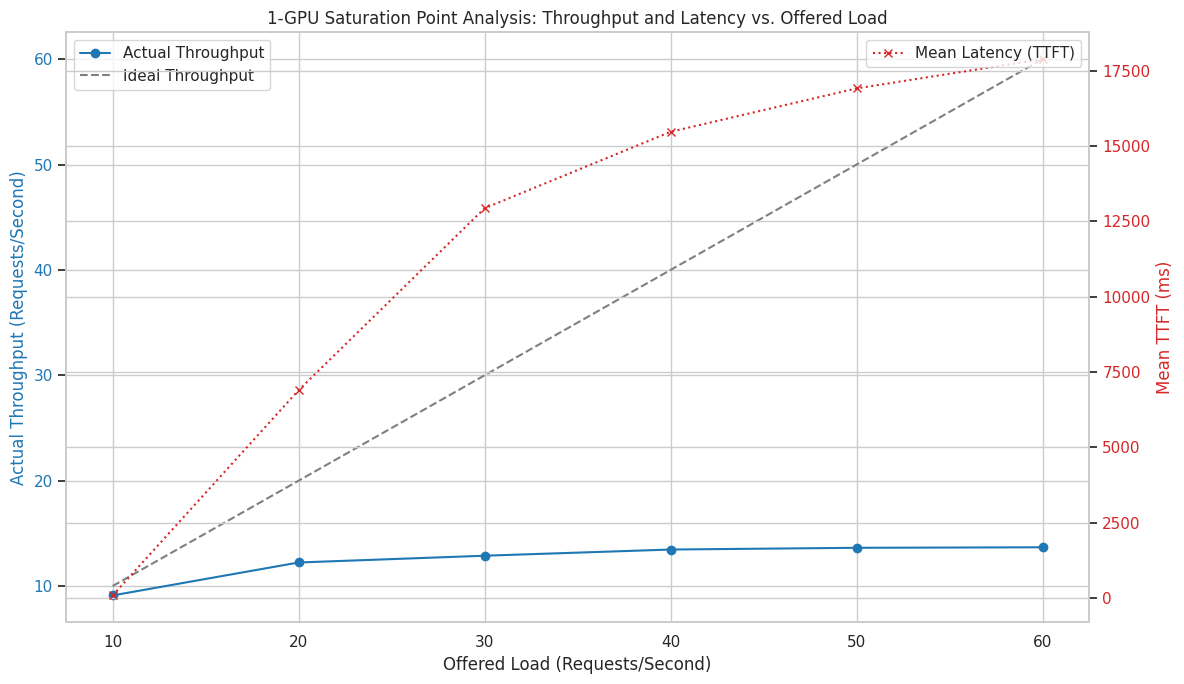

In [2]:
if not df_sat.empty:
    sns.set_theme(style="whitegrid")
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot Throughput on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Offered Load (Requests/Second)')
    ax1.set_ylabel('Actual Throughput (Requests/Second)', color=color)
    ax1.plot(df_sat['request_rate'], df_sat['request_throughput'], color=color, marker='o', label='Actual Throughput')
    ax1.plot(df_sat['request_rate'], df_sat['request_rate'], color='gray', linestyle='--', label='Ideal Throughput')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Plot Latency on the secondary y-axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Mean TTFT (ms)', color=color)
    ax2.plot(df_sat['request_rate'], df_sat['mean_ttft_ms'], color=color, marker='x', linestyle=':', label='Mean Latency (TTFT)')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    plt.title('1-GPU Saturation Point Analysis: Throughput and Latency vs. Offered Load')
    fig.tight_layout()
    plt.savefig('../results/figs/saturation_point_analysis.png')
    plt.show()

## 3. Results Summary Table

In [3]:
if 'df_sat' in locals() and not df_sat.empty:
    print("Saturation Test Results Summary Table:")
    display(df_sat.round(2))

Saturation Test Results Summary Table:


,gpu_count,request_rate,request_throughput,total_token_throughput,mean_ttft_ms
3,1,10,9.11,2726.22,87.58
1,1,20,12.24,3661.93,6899.91
0,1,30,12.88,3854.01,12938.31
2,1,40,13.47,4029.77,15475.87
4,1,50,13.63,4079.05,16916.01
5,1,60,13.68,4093.58,17886.71


### 결과 해석:

위 그래프와 표는 시스템의 포화점(Saturation Point)을 찾는 데 도움을 줍니다:

- **파란색 선 (실제 처리량):** 이 선은 초기에 점선으로 표시된 '이상적인 처리량'을 따라가야 합니다. 선이 수평에 가까워지기 시작하는 지점은 시스템이 더 이상 주어지는 부하(요청)를 감당하지 못한다는 것을 의미합니다. 이 선의 최상단이 시스템의 최대 처리량입니다.
- **빨간색 선 (지연 시간):** 이 선은 부하가 낮을 때는 비교적 평평하게 유지되어야 합니다. 선이 급격하게 위로 꺾이는 지점('하키 스틱' 또는 '엘보우' 지점)이 바로 포화점입니다. 이 지점을 넘어서면, 요청은 처리되는 시간보다 대기열(queue)에서 기다리는 데 더 많은 시간을 소비하게 되어 지연 시간이 기하급수적으로 증가합니다.